# Kaggle Competition: Playground Series S4E8 - Mushroom Classification

## Полный анализ и моделирование

**Цель проекта:**
- Превзойти результаты baseline на LAMA
- Продемонстрировать качественный код
- Использовать стандартные подходы к организации кода (Pipeline)
- Провести качественный EDA
- Предоставить подробное описание и обоснование гипотез

**Финальный Kaggle Score:** 0.98456

**Kaggle Score для LAMA** = 0.98224


# ЭТАП 1: Подготовка окружения и загрузка данных

## Шаг 1.1: Импорт библиотек и настройка окружения

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
import joblib
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

import optuna

from scipy.stats import chi2_contingency

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = PROJECT_ROOT / "playground-series-s4e8"
RESULTS_DIR = PROJECT_ROOT / "results"

sys.path.append(str(PROJECT_ROOT / "src" / "models" / "custom"))
from pipeline_utils import identify_feature_types, preprocess_data

## Шаг 1.2: Загрузка данных

In [12]:
# Загрузка данных
train_df = pd.read_csv(DATA_DIR / "train.csv")
test_df = pd.read_csv(DATA_DIR / "test.csv")
sample_submission = pd.read_csv(DATA_DIR / "sample_submission.csv")

print(f"\nTrain set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

print("\nТИПЫ ДАННЫХ:")
print(train_df.dtypes)

display(train_df.head())

print("\nБАЗОВАЯ СТАТИСТИКА:")
display(train_df.describe())


Train set: (3116945, 22)
Test set: (2077964, 21)

ТИПЫ ДАННЫХ:
id                        int64
class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a



БАЗОВАЯ СТАТИСТИКА:


,id,cap-diameter,stem-height,stem-width
count,3.116945e+06,3.116941e+06,3.116945e+06,3.116945e+06
mean,1.558472e+06,6.309848e+00,6.348333e+00,1.115379e+01
std,8.997847e+05,4.657931e+00,2.699755e+00,8.095477e+00
min,0.000000e+00,3.000000e-02,0.000000e+00,0.000000e+00
25%,7.792360e+05,3.320000e+00,4.670000e+00,4.970000e+00
50%,1.558472e+06,5.750000e+00,5.880000e+00,9.650000e+00
75%,2.337708e+06,8.240000e+00,7.410000e+00,1.563000e+01
max,3.116944e+06,8.067000e+01,8.872000e+01,1.029000e+02


# ЭТАП 2: EDA - Анализ целевой переменной

## Шаг 2.1: Численный анализ целевой переменной

In [13]:
target_col = 'class'

print("="*60)
print("ЧИСЛЕННЫЙ АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("="*60)

class_counts = train_df[target_col].value_counts()
class_percentages = train_df[target_col].value_counts(normalize=True) * 100

print(f"\nОбщее количество наблюдений: {len(train_df)}")
print(f"Количество пропущенных значений: {train_df[target_col].isna().sum()}")
print(f"\nРаспределение классов:")
for cls in class_counts.index:
    print(f"  {cls}: {class_counts[cls]:,} ({class_percentages[cls]:.2f}%)")

balance_diff = abs(class_percentages['e'] - class_percentages['p'])
print(f"\nРазница в балансе классов: {balance_diff:.2f}%")
if balance_diff < 10:
    print("Классы сбалансированы")
else:
    print("Обнаружен дисбаланс классов")

ЧИСЛЕННЫЙ АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

Общее количество наблюдений: 3116945
Количество пропущенных значений: 0

Распределение классов:
  p: 1,705,396 (54.71%)
  e: 1,411,549 (45.29%)

Разница в балансе классов: 9.43%
Классы сбалансированы


## Шаг 2.2: Визуализация целевой переменной

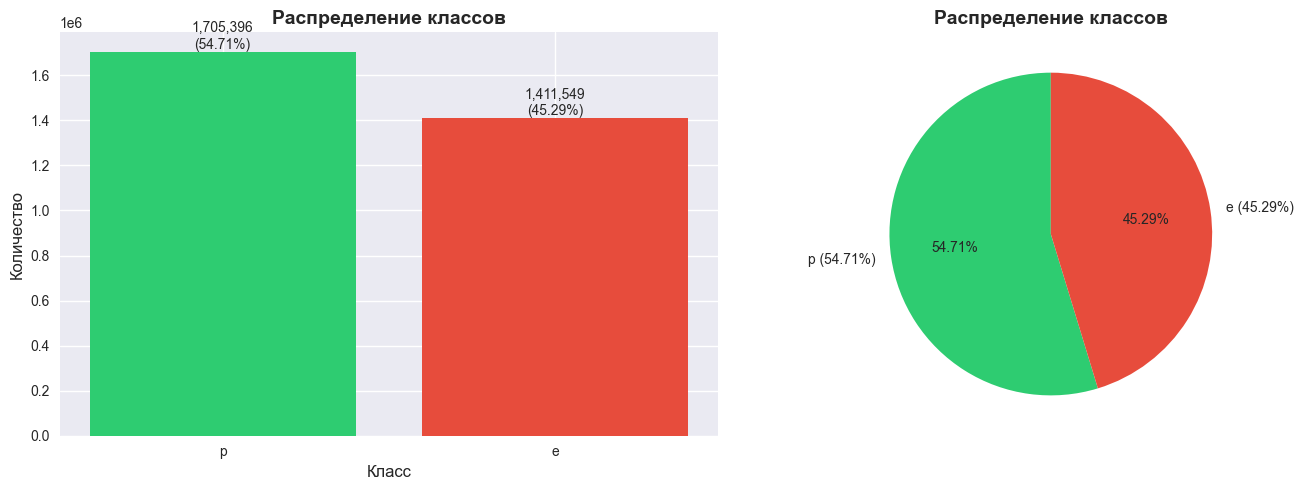

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(class_counts.index, class_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Распределение классов', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Класс', fontsize=12)
axes[0].set_ylabel('Количество', fontsize=12)
for i, (cls, count) in enumerate(class_counts.items()):
    axes[0].text(i, count, f'{count:,}\n({class_percentages[cls]:.2f}%)', 
                ha='center', va='bottom', fontsize=10)

axes[1].pie(class_counts.values, 
            labels=[f"{cls} ({pct:.2f}%)" for cls, pct in zip(class_counts.index, class_percentages.values)],
            autopct='%1.2f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Распределение классов', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / "eda" / "visualizations" / "target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# ЭТАП 3: EDA - Анализ признаков

## Шаг 3.1: Типизация признаков

In [15]:
feature_types = identify_feature_types(train_df)

print("="*60)
print("ТИПИЗАЦИЯ ПРИЗНАКОВ")
print("="*60)
print(f"\nЧисленные признаки ({len(feature_types['numeric'])}):")
for feat in feature_types['numeric']:
    print(f"  - {feat}")

print(f"\nКатегориальные признаки ({len(feature_types['categorical'])}):")
for feat in feature_types['categorical']:
    print(f"  - {feat}")

# Статистика для численных признаков
if feature_types['numeric']:
    numeric_stats = train_df[feature_types['numeric']].describe()
    print("\nСТАТИСТИКА ЧИСЛЕННЫХ ПРИЗНАКОВ:")
    display(numeric_stats)

ТИПИЗАЦИЯ ПРИЗНАКОВ

Численные признаки (3):
  - cap-diameter
  - stem-height
  - stem-width

Категориальные признаки (17):
  - cap-shape
  - cap-surface
  - cap-color
  - does-bruise-or-bleed
  - gill-attachment
  - gill-spacing
  - gill-color
  - stem-root
  - stem-surface
  - stem-color
  - veil-type
  - veil-color
  - has-ring
  - ring-type
  - spore-print-color
  - habitat
  - season

СТАТИСТИКА ЧИСЛЕННЫХ ПРИЗНАКОВ:


,cap-diameter,stem-height,stem-width
count,3.116941e+06,3.116945e+06,3.116945e+06
mean,6.309848e+00,6.348333e+00,1.115379e+01
std,4.657931e+00,2.699755e+00,8.095477e+00
min,3.000000e-02,0.000000e+00,0.000000e+00
25%,3.320000e+00,4.670000e+00,4.970000e+00
50%,5.750000e+00,5.880000e+00,9.650000e+00
75%,8.240000e+00,7.410000e+00,1.563000e+01
max,8.067000e+01,8.872000e+01,1.029000e+02


## Шаг 3.2: Визуализация распределений

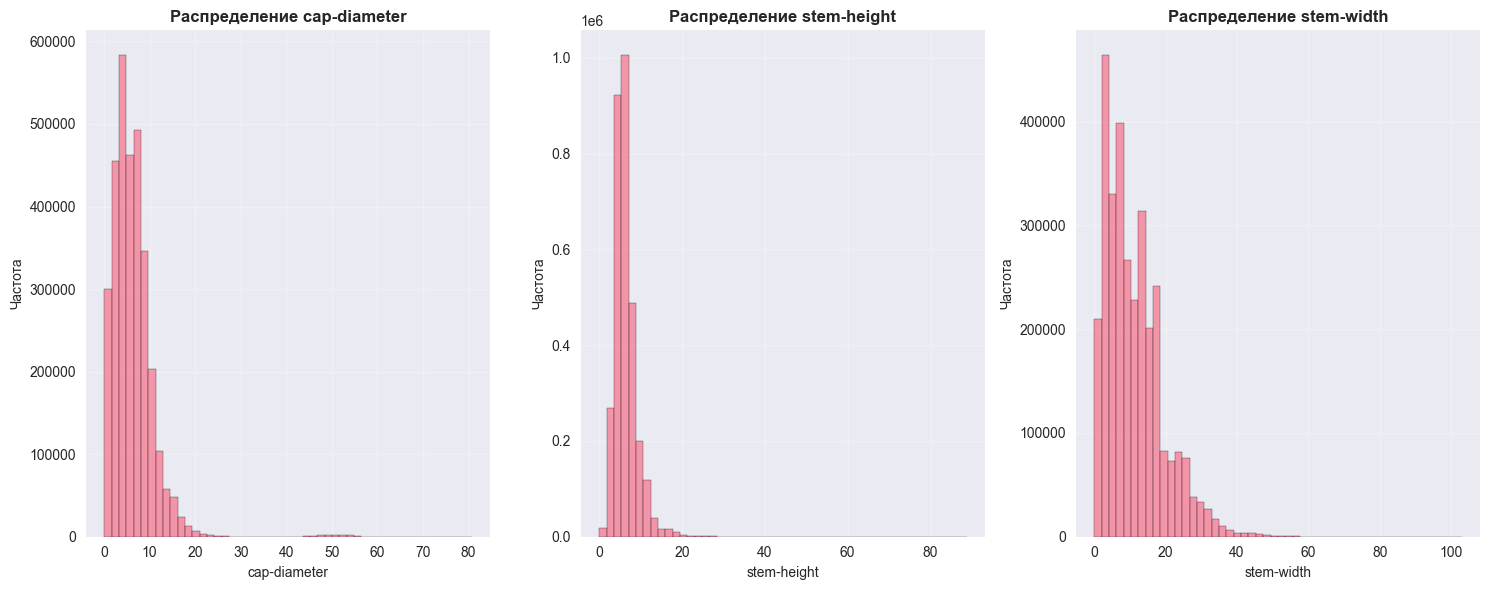

In [16]:
if feature_types['numeric']:
    n_numeric = len(feature_types['numeric'])
    fig, axes = plt.subplots(1, n_numeric, figsize=(5*n_numeric, 6))
    axes = axes if n_numeric > 1 else [axes]
    
    for i, feat in enumerate(feature_types['numeric']):
        axes[i].hist(train_df[feat].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Распределение {feat}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(feat, fontsize=10)
        axes[i].set_ylabel('Частота', fontsize=10)
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "eda" / "visualizations" / "numeric_distributions.png", dpi=300, bbox_inches='tight')
    plt.show()

## Шаг 3.3: Выявление аномальных значений

In [17]:
def detect_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers, lower_bound, upper_bound

outliers_report = []
for feat in feature_types['numeric']:
    iqr_outliers, lower, upper = detect_outliers_iqr(train_df, feat)
    outliers_report.append({
        'feature': feat,
        'iqr_outliers_count': len(iqr_outliers),
        'iqr_outliers_percentage': (len(iqr_outliers) / len(train_df)) * 100
    })

outliers_df = pd.DataFrame(outliers_report)
display(outliers_df)

,feature,iqr_outliers_count,iqr_outliers_percentage
0,cap-diameter,76124,2.442263
1,stem-height,132419,4.248359
2,stem-width,66481,2.132890


## Шаг 3.4: Анализ пропущенных значений

АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

Общее количество пропущенных значений: 15,868,508
Признаков с пропусками: 17


,feature,missing_count,missing_percentage
15,veil-type,2957493,94.884350
19,spore-print-color,2849682,91.425482
12,stem-root,2757023,88.452732
16,veil-color,2740947,87.936970
13,stem-surface,1980861,63.551362
8,gill-spacing,1258435,40.373988
4,cap-surface,671023,21.528227
7,gill-attachment,523936,16.809280
18,ring-type,128880,4.134818
9,gill-color,57,0.001829


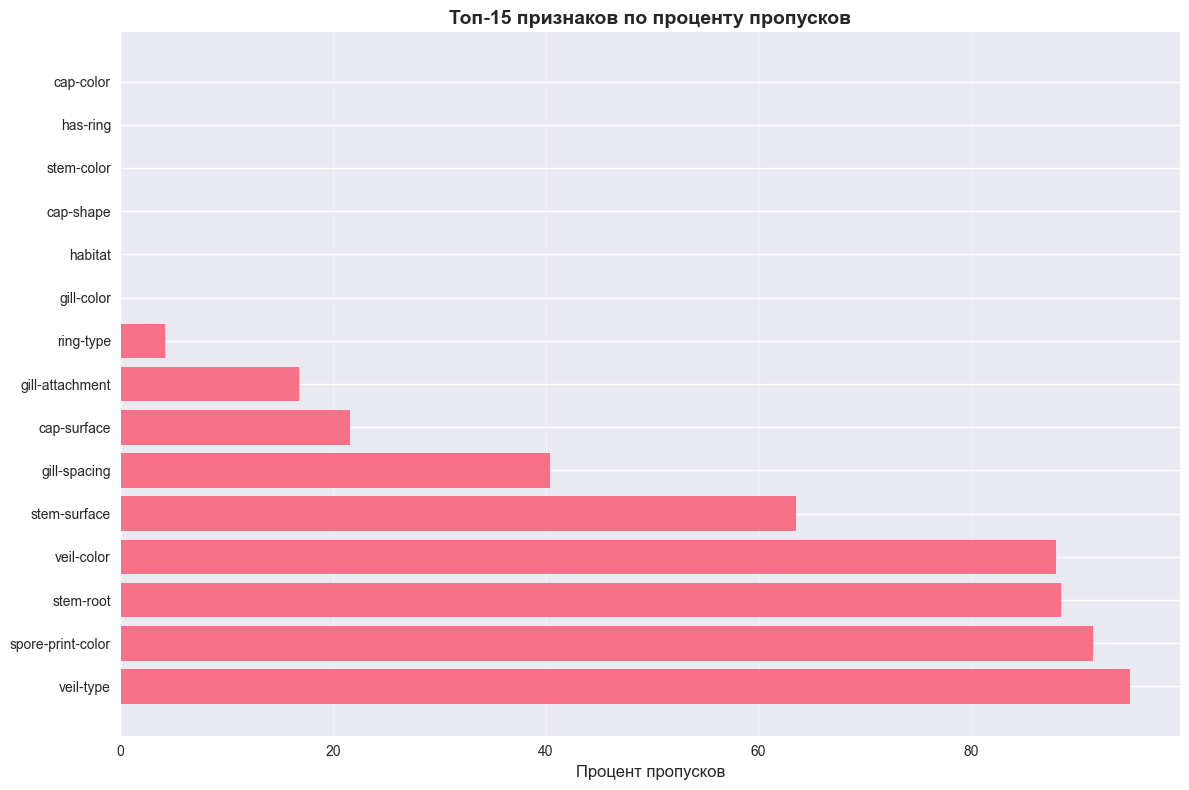

In [18]:
missing_stats = train_df.isnull().sum()
missing_percentage = (missing_stats / len(train_df)) * 100

missing_df = pd.DataFrame({
    'feature': missing_stats.index,
    'missing_count': missing_stats.values,
    'missing_percentage': missing_percentage.values
}).sort_values('missing_percentage', ascending=False)

missing_df = missing_df[missing_df['missing_count'] > 0]

print("="*60)
print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("="*60)
print(f"\nОбщее количество пропущенных значений: {missing_stats.sum():,}")
print(f"Признаков с пропусками: {len(missing_df)}")
display(missing_df.head(10))

# Визуализация
if len(missing_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    top_missing = missing_df.head(15)
    ax.barh(top_missing['feature'], top_missing['missing_percentage'])
    ax.set_xlabel('Процент пропусков', fontsize=12)
    ax.set_title('Топ-15 признаков по проценту пропусков', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "eda" / "visualizations" / "missing_values.png", dpi=300, bbox_inches='tight')
    plt.show()

## Шаг 3.5: Анализ зависимостей между признаками

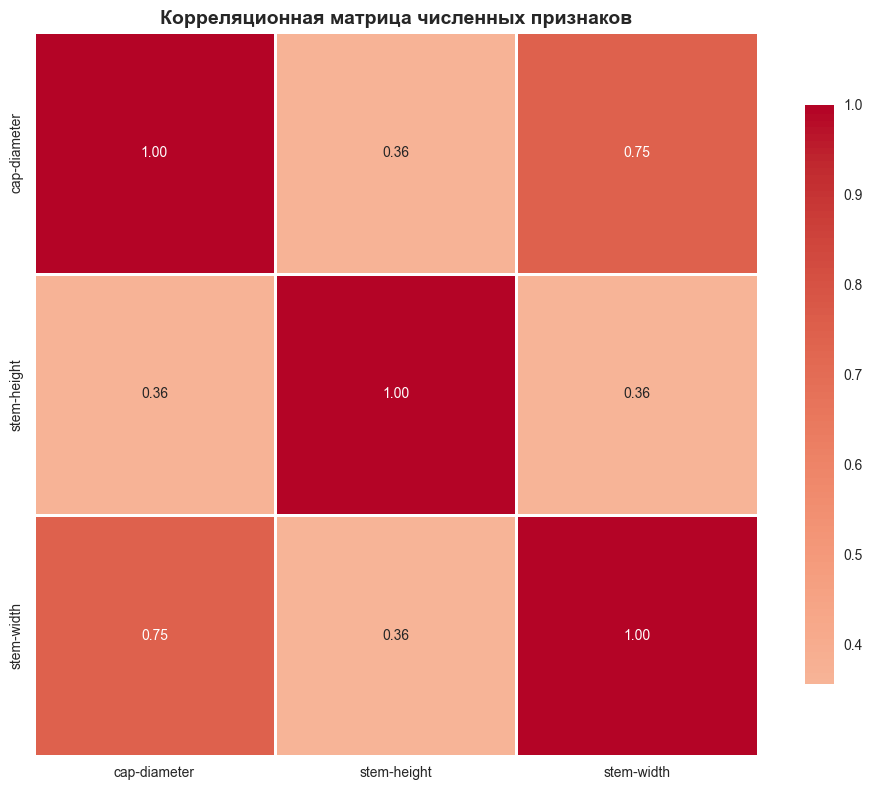


Сильно коррелированные пары (|corr| > 0.7):
  cap-diameter <-> stem-width: 0.746


In [19]:
if len(feature_types['numeric']) > 1:
    numeric_corr = train_df[feature_types['numeric']].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Корреляционная матрица численных признаков', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "eda" / "visualizations" / "correlation_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    high_corr_pairs = []
    for i in range(len(numeric_corr.columns)):
        for j in range(i+1, len(numeric_corr.columns)):
            corr_val = numeric_corr.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append({
                    'feature1': numeric_corr.columns[i],
                    'feature2': numeric_corr.columns[j],
                    'correlation': corr_val
                })
    
    if high_corr_pairs:
        print("\nСильно коррелированные пары (|corr| > 0.7):")
        for pair in high_corr_pairs:
            print(f"  {pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.3f}")

## Шаг 3.6: Определение важности признаков

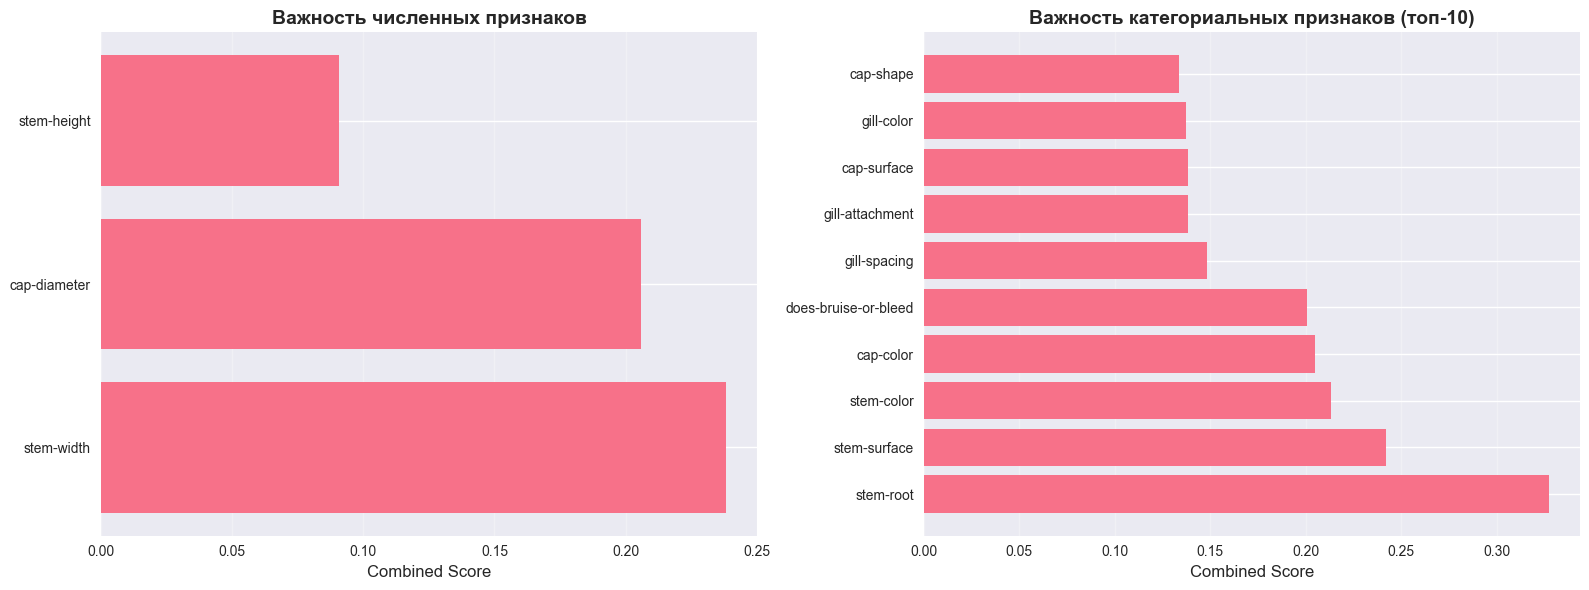


ТОП-10 ВАЖНЫХ ПРИЗНАКОВ:


,feature,combined_score,type
7,stem-root,0.327150,categorical
8,stem-surface,0.242115,categorical
2,stem-width,0.238215,numeric
9,stem-color,0.213073,categorical
0,cap-diameter,0.205763,numeric
2,cap-color,0.204618,categorical
3,does-bruise-or-bleed,0.200503,categorical
5,gill-spacing,0.148393,categorical
4,gill-attachment,0.138347,categorical
1,cap-surface,0.138300,categorical


In [20]:
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(train_df[target_col])

numeric_importance = []
for feat in feature_types['numeric']:
    corr = abs(train_df[feat].corr(pd.Series(y_encoded)))
    mi = mutual_info_classif(
        train_df[[feat]].fillna(train_df[feat].median()),
        y_encoded,
        random_state=42
    )[0]
    numeric_importance.append({
        'feature': feat,
        'correlation': corr,
        'mutual_information': mi,
        'combined_score': corr + mi
    })

numeric_imp_df = pd.DataFrame(numeric_importance).sort_values('combined_score', ascending=False)

categorical_importance = []
for feat in feature_types['categorical'][:10]:
    contingency_table = pd.crosstab(train_df[feat].fillna('missing'), y_encoded)
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    le_feat = LabelEncoder()
    feat_encoded = le_feat.fit_transform(train_df[feat].fillna('missing'))
    mi = mutual_info_classif(feat_encoded.reshape(-1, 1), y_encoded, random_state=42)[0]
    categorical_importance.append({
        'feature': feat,
        'chi2': chi2 / len(train_df),
        'mutual_information': mi,
        'combined_score': (chi2 / len(train_df)) + mi
    })

cat_imp_df = pd.DataFrame(categorical_importance).sort_values('combined_score', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
if len(numeric_imp_df) > 0:
    axes[0].barh(numeric_imp_df['feature'], numeric_imp_df['combined_score'])
    axes[0].set_xlabel('Combined Score', fontsize=12)
    axes[0].set_title('Важность численных признаков', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')

if len(cat_imp_df) > 0:
    top_cat = cat_imp_df.head(10)
    axes[1].barh(top_cat['feature'], top_cat['combined_score'])
    axes[1].set_xlabel('Combined Score', fontsize=12)
    axes[1].set_title('Важность категориальных признаков (топ-10)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_DIR / "eda" / "visualizations" / "feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

all_importance = pd.concat([
    numeric_imp_df[['feature', 'combined_score']].assign(type='numeric'),
    cat_imp_df[['feature', 'combined_score']].assign(type='categorical')
]).sort_values('combined_score', ascending=False)

print("\nТОП-10 ВАЖНЫХ ПРИЗНАКОВ:")
display(all_importance.head(10))

# ЭТАП 4: Моделирование - LAMA Baseline (0.25 балла)

## Шаг 4.1: Подготовка данных для LAMA

In [21]:
import sys
import os
if sys.platform == 'darwin':
    libomp_path = '/opt/homebrew/opt/libomp/lib'
    if os.path.exists(libomp_path):
        os.environ['DYLD_LIBRARY_PATH'] = libomp_path + ':' + os.environ.get('DYLD_LIBRARY_PATH', '')

from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML
from lightautoml.tasks import Task

train_lama, val_lama = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df[target_col],
    random_state=42
)

print("="*60)
print("ПОДГОТОВКА ДАННЫХ ДЛЯ LAMA")
print("="*60)
print(f"\nTrain: {train_lama.shape}")
print(f"Val: {val_lama.shape}")
print(f"\nРаспределение классов в train:")
print(train_lama[target_col].value_counts(normalize=True))
print(f"\nРаспределение классов в val:")
print(val_lama[target_col].value_counts(normalize=True))

sample_size = min(3000, len(train_lama))
train_lama_sample = train_lama.sample(n=sample_size, random_state=42)
print(f"\nИспользуется выборка: {sample_size} строк из {len(train_lama)} для ускорения")

'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
ПОДГОТОВКА ДАННЫХ ДЛЯ LAMA

Train: (2493556, 22)
Val: (623389, 22)

Распределение классов в train:
class
p    0.547137
e    0.452863
Name: proportion, dtype: float64

Распределение классов в val:
class
p    0.547137
e    0.452863
Name: proportion, dtype: float64

Используется выборка: 3000 строк из 2493556 для ускорения


## Шаг 4.2: Обучение LAMA - Конфигурация 1


In [22]:
print("="*60)
print("ОБУЧЕНИЕ LAMA CONFIG 1")
print("="*60)

task = Task('binary', metric='auc')

automl_config1 = TabularUtilizedAutoML(
    task=task,
    timeout=300, 
    cpu_limit=1, 
    random_state=42
)

roles = {
    'target': target_col,
    'drop': ['id']
}

print("\nНачало обучения модели Config 1...")

automl_config1.fit_predict(
    train_data=train_lama_sample,
    roles=roles,
    verbose=1
)

print("Модель Config 1 обучена успешно")

pred_config1 = automl_config1.predict(val_lama)

y_val_lama = val_lama[target_col]
le_lama = LabelEncoder()
y_val_lama_encoded = le_lama.fit_transform(y_val_lama)

if hasattr(pred_config1, 'data'):
    pred_data = pred_config1.data
    if len(pred_data.shape) > 1 and pred_data.shape[1] > 1:
        pred_probs_config1 = pred_data[:, 1]
        pred_classes_config1 = (pred_probs_config1 > 0.5).astype(int)
    elif len(pred_data.shape) > 1 and pred_data.shape[1] == 1:
        pred_probs_config1 = pred_data[:, 0]
        pred_classes_config1 = (pred_probs_config1 > 0.5).astype(int)
    else:
        pred_probs_config1 = pred_data.flatten()
        pred_classes_config1 = (pred_probs_config1 > 0.5).astype(int)
else:
    pred_probs_config1 = np.array(pred_config1).flatten()
    pred_classes_config1 = (pred_probs_config1 > 0.5).astype(int)

accuracy_config1 = accuracy_score(y_val_lama_encoded, pred_classes_config1)
f1_config1 = f1_score(y_val_lama_encoded, pred_classes_config1, average='weighted')
roc_auc_config1 = roc_auc_score(y_val_lama_encoded, pred_probs_config1)

print("\n" + "="*60)
print("МЕТРИКИ LAMA CONFIG 1")
print("="*60)
print(f"Accuracy: {accuracy_config1:.6f}")
print(f"F1-Score: {f1_config1:.6f}")
print(f"ROC-AUC: {roc_auc_config1:.6f}")

ОБУЧЕНИЕ LAMA CONFIG 1

Начало обучения модели Config 1...
[16:49:19] Start automl utilizator with listed constraints:
[16:49:19] - time: 300.00 seconds
[16:49:19] - CPU: 1 cores
[16:49:19] - memory: 16 GB

[16:49:19] If one preset completes earlier, next preset configuration will be started

[16:49:19] ==================================================
[16:49:19] Start 0 automl preset configuration:
[16:49:19] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[16:49:19] Stdout logging level is INFO.
[16:49:19] Task: binary

[16:49:19] Start automl preset with listed constraints:
[16:49:19] - time: 300.00 seconds
[16:49:19] - CPU: 1 cores
[16:49:19] - memory: 16 GB

[16:49:19] Train data shape: (3000, 22)

[16:49:19] Layer 1 train process start. Time left 299.93 secs
[16:49:19] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:49:21] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 fin

Optimization Progress:  33%|███▎      | 33/101 [00:58<02:00,  1.77s/it, best_trial=22, best_value=0.992]

[16:50:24] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:50:24] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[16:50:26] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9904008787557148
[16:50:26] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[16:50:26] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[16:50:28] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9851705511541924
[16:50:28] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[16:50:28] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 193.97 secs


Optimization Progress: 100%|██████████| 101/101 [01:17<00:00,  1.30it/s, best_trial=79, best_value=0.99]

[16:51:46] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[16:51:46] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[16:51:52] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9912222583611402
[16:51:52] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[16:51:52] Time left 147.35 secs

[16:51:52] Layer 1 training completed.

[16:51:52] Blending: optimization starts with equal weights. Score = 0.9894037
[16:51:52] Blending: iteration 0: score = 0.9913383, weights = [0.         0.         0.15507849 0.         0.8449215 ]
[16:51:52] Blending: no improvements for score. Terminated.

[16:51:52] Blending: best score = 0.9913383, best weights = [0.         0.         0.15507849 0.         0.8449215 ]
[16:51:52] Automl preset training completed in 152.71 seconds

[16:51:52] Model description:
Final prediction for new objects (level 0) = 
	 0.15508 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.84492 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 

[16:51:52] ==================================================
Модель Config 1 обучена успешно

МЕТРИКИ LAM

## Шаг 4.3: Обучение LAMA - Конфигурация 2


In [23]:
print("="*60)
print("ОБУЧЕНИЕ LAMA CONFIG 2")
print("="*60)

automl_config2 = TabularUtilizedAutoML(
    task=task,
    timeout=300,
    cpu_limit=1,
    random_state=42,
    max_runs_per_config=2
)

print("\nНачало обучения модели Config 2...")

automl_config2.fit_predict(
    train_data=train_lama_sample,
    roles=roles,
    verbose=1
)

print("Модель Config 2 обучена успешно")

pred_config2 = automl_config2.predict(val_lama)

if hasattr(pred_config2, 'data'):
    pred_data = pred_config2.data
    if len(pred_data.shape) > 1 and pred_data.shape[1] > 1:
        pred_probs_config2 = pred_data[:, 1]
        pred_classes_config2 = (pred_probs_config2 > 0.5).astype(int)
    elif len(pred_data.shape) > 1 and pred_data.shape[1] == 1:
        pred_probs_config2 = pred_data[:, 0]
        pred_classes_config2 = (pred_probs_config2 > 0.5).astype(int)
    else:
        pred_probs_config2 = pred_data.flatten()
        pred_classes_config2 = (pred_probs_config2 > 0.5).astype(int)
else:
    pred_probs_config2 = np.array(pred_config2).flatten()
    pred_classes_config2 = (pred_probs_config2 > 0.5).astype(int)

accuracy_config2 = accuracy_score(y_val_lama_encoded, pred_classes_config2)
f1_config2 = f1_score(y_val_lama_encoded, pred_classes_config2, average='weighted')
roc_auc_config2 = roc_auc_score(y_val_lama_encoded, pred_probs_config2)

print("\n" + "="*60)
print("МЕТРИКИ LAMA CONFIG 2")
print("="*60)
print(f"Accuracy: {accuracy_config2:.6f}")
print(f"F1-Score: {f1_config2:.6f}")
print(f"ROC-AUC: {roc_auc_config2:.6f}")


ОБУЧЕНИЕ LAMA CONFIG 2

Начало обучения модели Config 2...
[16:52:11] Start automl utilizator with listed constraints:
[16:52:11] - time: 300.00 seconds
[16:52:11] - CPU: 1 cores
[16:52:11] - memory: 16 GB

[16:52:11] If one preset completes earlier, next preset configuration will be started

[16:52:11] ==================================================
[16:52:11] Start 0 automl preset configuration:
[16:52:11] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[16:52:11] Stdout logging level is INFO.
[16:52:11] Task: binary

[16:52:11] Start automl preset with listed constraints:
[16:52:11] - time: 300.00 seconds
[16:52:11] - CPU: 1 cores
[16:52:11] - memory: 16 GB

[16:52:11] Train data shape: (3000, 22)

[16:52:11] Layer 1 train process start. Time left 299.92 secs
[16:52:11] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:52:12] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 fin

Optimization Progress:  33%|███▎      | 33/101 [00:58<02:00,  1.78s/it, best_trial=22, best_value=0.992]

[16:53:16] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:53:16] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[16:53:18] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9904008787557148
[16:53:18] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[16:53:18] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[16:53:20] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9851705511541924
[16:53:20] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[16:53:20] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 195.06 secs


Optimization Progress: 100%|██████████| 101/101 [01:19<00:00,  1.28it/s, best_trial=79, best_value=0.99]

[16:54:39] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[16:54:39] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[16:54:45] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9912222583611402
[16:54:45] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[16:54:45] Time left 145.82 secs

[16:54:45] Layer 1 training completed.

[16:54:45] Blending: optimization starts with equal weights. Score = 0.9894037
[16:54:45] Blending: iteration 0: score = 0.9913383, weights = [0.         0.         0.15507849 0.         0.8449215 ]
[16:54:45] Blending: no improvements for score. Terminated.

[16:54:45] Blending: best score = 0.9913383, best weights = [0.         0.         0.15507849 0.         0.8449215 ]
[16:54:45] Automl preset training completed in 154.24 seconds

[16:54:45] Model description:
Final prediction for new objects (level 0) = 
	 0.15508 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.84492 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 

[16:54:45] ==================================================
Модель Config 2 обучена успешно

МЕТРИКИ LAM

## Шаг 4.4: Сравнение конфигураций и выбор лучшей


СРАВНЕНИЕ КОНФИГУРАЦИЙ LAMA


,Config,ROC-AUC,Accuracy,F1-Score
0,Config 1,0.007278,0.027087,0.027266
1,Config 2,0.007278,0.027087,0.027266



Лучшая конфигурация: CONFIG1
  ROC-AUC: 0.007278


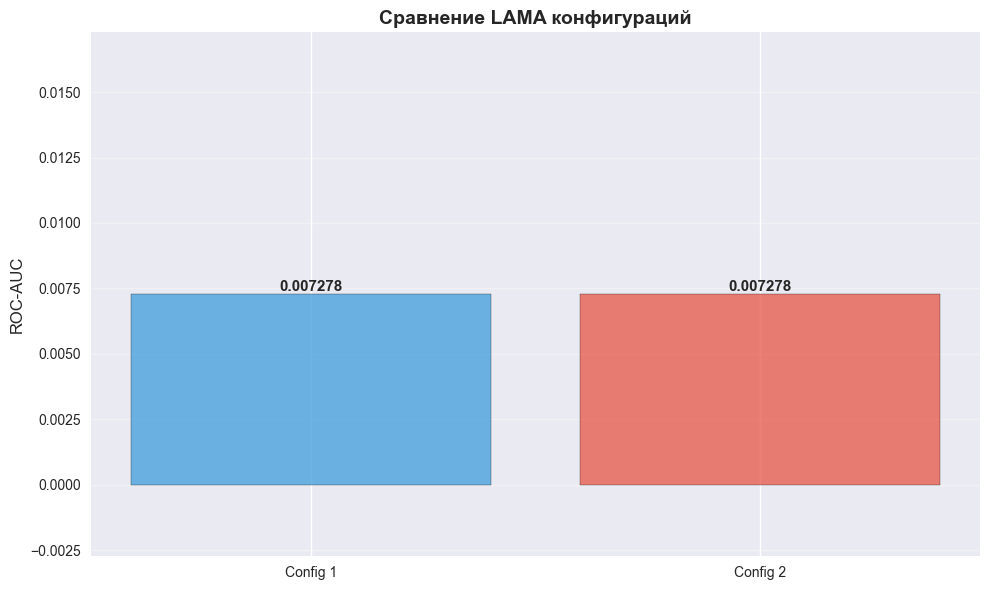

In [24]:
print("="*60)
print("СРАВНЕНИЕ КОНФИГУРАЦИЙ LAMA")
print("="*60)

comparison_lama = pd.DataFrame({
    'Config': ['Config 1', 'Config 2'],
    'ROC-AUC': [roc_auc_config1, roc_auc_config2],
    'Accuracy': [accuracy_config1, accuracy_config2],
    'F1-Score': [f1_config1, f1_config2]
})

display(comparison_lama)

if roc_auc_config1 >= roc_auc_config2:
    best_config = 'config1'
    best_model = automl_config1
    best_roc_auc = roc_auc_config1
else:
    best_config = 'config2'
    best_model = automl_config2
    best_roc_auc = roc_auc_config2

print(f"\nЛучшая конфигурация: {best_config.upper()}")
print(f"  ROC-AUC: {best_roc_auc:.6f}")

fig, ax = plt.subplots(figsize=(10, 6))
configs = ['Config 1', 'Config 2']
roc_aucs = [roc_auc_config1, roc_auc_config2]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(configs, roc_aucs, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('Сравнение LAMA конфигураций', fontsize=14, fontweight='bold')
ax.set_ylim([min(roc_aucs) - 0.01, max(roc_aucs) + 0.01])
ax.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, roc_aucs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.6f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / "baseline" / "lama_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


### Обучение финальной модели на полном train set и создание submission


In [25]:
print("="*60)
print("ОБУЧЕНИЕ ФИНАЛЬНОЙ LAMA МОДЕЛИ")
print("="*60)

print("Для демонстрации используется выборка.")

final_sample_size = min(2000, len(train_df))
train_final_sample = train_df.sample(n=final_sample_size, random_state=42)
print(f"\nИспользуется выборка: {final_sample_size} строк из {len(train_df)}")

if best_config == 'config1':
    final_lama = TabularUtilizedAutoML(
        task=task,
        timeout=600,
        cpu_limit=1,
        random_state=42
    )
else:
    final_lama = TabularUtilizedAutoML(
        task=task,
        timeout=600,
        cpu_limit=1,
        random_state=42,
        max_runs_per_config=3
    )

print("\nНачало обучения финальной модели...")
final_lama.fit_predict(
    train_data=train_final_sample,
    roles=roles,
    verbose=1
)

print("\nФинальная модель обучена")

print("\nСоздание submission файла...")
pred_final = final_lama.predict(test_df)

if hasattr(pred_final, 'data'):
    pred_data = pred_final.data
    if len(pred_data.shape) > 1 and pred_data.shape[1] > 1:
        probs_p = pred_data[:, 1]
    elif len(pred_data.shape) > 1 and pred_data.shape[1] == 1:
        probs_p = pred_data[:, 0]
    else:
        probs_p = pred_data.flatten()
else:
    probs_p = np.array(pred_final).flatten()

classes = ['e' if p > 0.5 else 'p' for p in probs_p]

submission_lama = pd.DataFrame({
    'id': test_df['id'],
    'class': classes
})

submission_path = RESULTS_DIR / "baseline" / "submissions" / "lama_best_submission.csv"
submission_path.parent.mkdir(parents=True, exist_ok=True)
submission_lama.to_csv(submission_path, index=False)

print("\n" + "="*60)
print("LAMA BASELINE ЗАВЕРШЕН")
print("="*60)
print(f"\n✓ Submission файл создан: {submission_path}")
print(f"Размер submission: {submission_lama.shape}")
print(f"\nРаспределение классов:")
print(submission_lama['class'].value_counts())
print(f"\nЛучшая конфигурация: {best_config.upper()}")
print(f"Validation ROC-AUC: {best_roc_auc:.6f}")


ОБУЧЕНИЕ ФИНАЛЬНОЙ LAMA МОДЕЛИ
Для демонстрации используется выборка.

Используется выборка: 2000 строк из 3116945

Начало обучения финальной модели...
[16:55:05] Start automl utilizator with listed constraints:
[16:55:05] - time: 600.00 seconds
[16:55:05] - CPU: 1 cores
[16:55:05] - memory: 16 GB

[16:55:05] If one preset completes earlier, next preset configuration will be started

[16:55:05] ==================================================
[16:55:05] Start 0 automl preset configuration:
[16:55:05] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[16:55:05] Stdout logging level is INFO.
[16:55:05] Task: binary

[16:55:05] Start automl preset with listed constraints:
[16:55:05] - time: 600.00 seconds
[16:55:05] - CPU: 1 cores
[16:55:05] - memory: 16 GB

[16:55:05] Train data shape: (2000, 22)

[16:55:05] Layer 1 train process start. Time left 599.93 secs
[16:55:05] Sta

Optimization Progress: 100%|██████████| 101/101 [01:44<00:00,  1.03s/it, best_trial=74, best_value=0.996]

[16:56:52] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:56:52] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[16:56:54] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9891471038092585
[16:56:54] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[16:56:54] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[16:56:55] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9846564241639122
[16:56:55] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[16:56:55] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [01:12<00:00,  1.40it/s, best_trial=51, best_value=0.995]

[16:58:07] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[16:58:07] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[16:58:14] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9894982061495373
[16:58:14] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[16:58:14] Time left 410.94 secs

[16:58:14] Layer 1 training completed.

[16:58:14] Blending: optimization starts with equal weights. Score = 0.9868306
[16:58:14] Blending: iteration 0: score = 0.9905001, weights = [0.         0.         0.60078025 0.         0.39921975]
[16:58:14] Blending: no improvements for score. Terminated.

[16:58:14] Blending: best score = 0.9905001, best weights = [0.         0.         0.60078025 0.         0.39921975]
[16:58:14] Automl preset training completed in 189.11 seconds

[16:58:14] Model description:
Final prediction for new objects (level 0) = 
	 0.60078 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.39922 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 

[16:58:14] ==================================================
[16:58:14] Start 1 automl preset configurati

Optimization Progress:  89%|████████▉ | 90/101 [01:21<00:09,  1.11it/s, best_trial=67, best_value=0.99] 

[16:59:40] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:59:40] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[16:59:41] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9865703354843397
[16:59:41] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[16:59:41] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[16:59:42] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.983024504521956
[16:59:42] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[16:59:42] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 238.06 secs


Optimization Progress: 100%|██████████| 101/101 [00:35<00:00,  2.83it/s, best_trial=21, best_value=0.993]

[17:00:17] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[17:00:17] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[17:00:20] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.989387729982122
[17:00:20] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[17:00:20] Time left 284.93 secs

[17:00:20] Layer 1 training completed.

[17:00:20] Blending: optimization starts with equal weights. Score = 0.9871242
[17:00:20] Blending: iteration 0: score = 0.9904516, weights = [0.         0.         0.19403611 0.         0.80596393]
[17:00:20] Blending: iteration 1: score = 0.9905868, weights = [0.         0.         0.34749493 0.         0.6525051 ]
[17:00:20] Blending: no improvements for score. Terminated.

[17:00:20] Blending: best score = 0.9905868, best weights = [0.         0.         0.34749493 0.         0.6525051 ]
[17:00:20] Automl preset training completed in 126.03 seconds

[17:00:20] Model description:
Final prediction for new objects (level 0) = 
	 0.34749 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.65251 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned

Optimization Progress:  92%|█████████▏| 93/101 [00:54<00:04,  1.72it/s, best_trial=87, best_value=0.987]

[17:01:18] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[17:01:18] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[17:01:19] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9900742964837302
[17:01:19] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:01:19] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[17:01:20] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9874132837754399
[17:01:20] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[17:01:20] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 163.10 secs


Optimization Progress: 100%|██████████| 101/101 [01:05<00:00,  1.54it/s, best_trial=94, best_value=0.986]

[17:02:26] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[17:02:26] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[17:02:31] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9914126219273499
[17:02:31] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[17:02:31] Time left 153.33 secs

[17:02:31] Layer 1 training completed.

[17:02:31] Blending: optimization starts with equal weights. Score = 0.9908068
[17:02:31] Blending: iteration 0: score = 0.9916714, weights = [0.05098569 0.         0.35345802 0.15139455 0.44416174]
[17:02:31] Blending: iteration 1: score = 0.9920023, weights = [0.05160658 0.         0.3032722  0.         0.6451212 ]
[17:02:31] Blending: no improvements for score. Terminated.

[17:02:31] Blending: best score = 0.9920023, best weights = [0.05160658 0.         0.3032722  0.         0.6451212 ]
[17:02:31] Automl preset training completed in 131.60 seconds

[17:02:31] Model description:
Final prediction for new objects (level 0) = 
	 0.05161 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.30327 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_Ligh

Optimization Progress:  29%|██▊       | 29/101 [00:24<01:00,  1.20it/s, best_trial=14, best_value=0.99] 

[17:03:00] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[17:03:00] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[17:03:01] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9837100621087933
[17:03:01] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:03:01] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[17:03:02] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.980962282730204
[17:03:02] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[17:03:02] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 89.50 secs


Optimization Progress: 100%|██████████| 101/101 [00:23<00:00,  4.33it/s, best_trial=90, best_value=0.986]

[17:03:25] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[17:03:25] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[17:03:26] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9844077266728817
[17:03:26] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[17:03:26] Time left 98.24 secs

[17:03:26] Layer 1 training completed.

[17:03:26] Blending: optimization starts with equal weights. Score = 0.9884570
[17:03:26] Blending: iteration 0: score = 0.9901419, weights = [0.1784896  0.         0.27571478 0.16160277 0.3841929 ]
[17:03:26] Blending: iteration 1: score = 0.9904678, weights = [0.225535   0.         0.26871878 0.         0.50574625]
[17:03:26] Blending: no improvements for score. Terminated.

[17:03:26] Blending: best score = 0.9904678, best weights = [0.225535   0.         0.26871878 0.         0.50574625]
[17:03:26] Automl preset training completed in 55.06 seconds

[17:03:26] Model description:
Final prediction for new objects (level 0) = 
	 0.22554 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.26872 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightG

# Kaggle Score для LAMA = 0.98224

# ЭТАП 5: Моделирование - Собственное решение (3 балла)

## Шаг 5.1: Обоснование стратегии разделения данных

In [26]:
print("\n1. Временные зависимости:")
print("   Нет явных временных зависимостей (ID не является временной меткой)")

print("\n2. Распределение признаков train vs test:")
for feat in feature_types['numeric'][:3]:
    train_mean = train_df[feat].mean()
    test_mean = test_df[feat].mean()
    diff = abs(train_mean - test_mean) / train_mean * 100
    print(f"   {feat}: diff={diff:.2f}%")

print("\n3. Выбранная стратегия:")
print("   - Stratified 80/20 split")
print("   - Обоснование: Сохранение баланса классов, отсутствие временных зависимостей")

train_custom, val_custom = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df[target_col],
    random_state=42
)

print(f"\nTrain={train_custom.shape}, Val={val_custom.shape}")


1. Временные зависимости:
   Нет явных временных зависимостей (ID не является временной меткой)

2. Распределение признаков train vs test:
   cap-diameter: diff=0.06%
   stem-height: diff=0.03%
   stem-width: diff=0.05%

3. Выбранная стратегия:
   - Stratified 80/20 split
   - Обоснование: Сохранение баланса классов, отсутствие временных зависимостей

Train=(2493556, 22), Val=(623389, 22)


## Шаг 5.2: Построение Pipeline - Попытка 1

In [27]:
X_train, X_val, y_train, y_val, feature_names = preprocess_data(
    train_custom, val_custom,
    feature_types['numeric'],
    feature_types['categorical']
)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")

feature_selector = SelectKBest(score_func=f_classif, k=100)
X_train_selected = feature_selector.fit_transform(X_train, y_train)
X_val_selected = feature_selector.transform(X_val)

selected_features = X_train.columns[feature_selector.get_support()].tolist()
X_train_final = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_val_final = pd.DataFrame(X_val_selected, columns=selected_features, index=X_val.index)

print(f"После feature selection: {X_train_final.shape[1]} признаков")

model_v1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("\nОбучение модели...")
model_v1.fit(X_train_final, y_train)

y_pred_v1 = model_v1.predict(X_val_final)
y_pred_proba_v1 = model_v1.predict_proba(X_val_final)[:, 1]

accuracy_v1 = accuracy_score(y_val, y_pred_v1)
f1_v1 = f1_score(y_val, y_pred_v1, average='weighted')
roc_auc_v1 = roc_auc_score(y_val, y_pred_proba_v1)

print("\n" + "="*60)
print("МЕТРИКИ PIPELINE V1")
print("="*60)
print(f"Accuracy: {accuracy_v1:.6f}")
print(f"F1-Score: {f1_v1:.6f}")
print(f"ROC-AUC: {roc_auc_v1:.6f}")

X_train: (2493556, 823)
X_val: (623389, 823)
После feature selection: 100 признаков

Обучение модели...

МЕТРИКИ PIPELINE V1
Accuracy: 0.963506
F1-Score: 0.963465
ROC-AUC: 0.993120


## Шаг 5.3: Оптимизация гиперпараметров

In [28]:
def objective(trial):
    n_features = trial.suggest_int('n_features', 50, 150, step=10)
    n_estimators = trial.suggest_int('n_estimators', 100, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 10, 20, step=2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    selector = SelectKBest(score_func=f_classif, k=n_features)
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_val_sel = selector.transform(X_val)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    sample_size = min(50000, len(X_train_sel))
    sample_indices = np.random.choice(len(X_train_sel), size=sample_size, replace=False)
    
    model.fit(X_train_sel[sample_indices], y_train[sample_indices])
    y_pred_proba = model.predict_proba(X_val_sel)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    return roc_auc

study = optuna.create_study(direction='maximize', study_name='pipeline_v1_optimization')

print("Начало оптимизации гиперпараметров (20 trials для демонстрации)...")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ")
print("="*60)
print(f"Лучший ROC-AUC: {study.best_value:.6f}")
print(f"\nЛучшие параметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_params = study.best_params
best_selector = SelectKBest(score_func=f_classif, k=best_params['n_features'])
X_train_best = best_selector.fit_transform(X_train, y_train)
X_val_best = best_selector.transform(X_val)

best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train_best, y_train)
y_pred_best = best_model.predict(X_val_best)
y_pred_proba_best = best_model.predict_proba(X_val_best)[:, 1]

accuracy_best = accuracy_score(y_val, y_pred_best)
f1_best = f1_score(y_val, y_pred_best, average='weighted')
roc_auc_best = roc_auc_score(y_val, y_pred_proba_best)

print("\n" + "="*60)
print("МЕТРИКИ ОПТИМИЗИРОВАННОЙ МОДЕЛИ")
print("="*60)
print(f"Accuracy: {accuracy_best:.6f}")
print(f"F1-Score: {f1_best:.6f}")
print(f"ROC-AUC: {roc_auc_best:.6f}")

Начало оптимизации гиперпараметров (20 trials для демонстрации)...


Best trial: 0. Best value: 0.993861:   5%|▌         | 1/20 [00:45<14:18, 45.21s/it]

[I 2025-12-10 17:08:28,852] Trial 0 finished with value: 0.993861140826403 and parameters: {'n_features': 90, 'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.993861140826403.


Best trial: 0. Best value: 0.993861:  10%|█         | 2/20 [01:29<13:22, 44.56s/it]

[I 2025-12-10 17:09:12,956] Trial 1 finished with value: 0.9936738043827416 and parameters: {'n_features': 50, 'n_estimators': 200, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.993861140826403.


Best trial: 2. Best value: 0.996235:  15%|█▌        | 3/20 [02:13<12:35, 44.42s/it]

[I 2025-12-10 17:09:57,215] Trial 2 finished with value: 0.9962346073634827 and parameters: {'n_features': 110, 'n_estimators': 250, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.9962346073634827.


Best trial: 2. Best value: 0.996235:  20%|██        | 4/20 [02:57<11:49, 44.35s/it]

[I 2025-12-10 17:10:41,451] Trial 3 finished with value: 0.9943319110426257 and parameters: {'n_features': 80, 'n_estimators': 250, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.9962346073634827.


Best trial: 4. Best value: 0.996541:  25%|██▌       | 5/20 [03:41<11:02, 44.20s/it]

[I 2025-12-10 17:11:25,381] Trial 4 finished with value: 0.9965411905670426 and parameters: {'n_features': 130, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 4 with value: 0.9965411905670426.


Best trial: 4. Best value: 0.996541:  30%|███       | 6/20 [04:25<10:18, 44.19s/it]

[I 2025-12-10 17:12:09,562] Trial 5 finished with value: 0.9951693049936169 and parameters: {'n_features': 100, 'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 4 with value: 0.9965411905670426.


Best trial: 4. Best value: 0.996541:  35%|███▌      | 7/20 [05:09<09:33, 44.10s/it]

[I 2025-12-10 17:12:53,462] Trial 6 finished with value: 0.9964029941834728 and parameters: {'n_features': 150, 'n_estimators': 150, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.9965411905670426.


Best trial: 4. Best value: 0.996541:  40%|████      | 8/20 [05:54<08:49, 44.17s/it]

[I 2025-12-10 17:13:37,775] Trial 7 finished with value: 0.9959463851192196 and parameters: {'n_features': 120, 'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.9965411905670426.


Best trial: 4. Best value: 0.996541:  45%|████▌     | 9/20 [06:37<08:02, 43.84s/it]

[I 2025-12-10 17:14:20,895] Trial 8 finished with value: 0.9945335388230979 and parameters: {'n_features': 50, 'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 4 with value: 0.9965411905670426.


Best trial: 4. Best value: 0.996541:  50%|█████     | 10/20 [07:21<07:21, 44.10s/it]

[I 2025-12-10 17:15:05,588] Trial 9 finished with value: 0.9963019248487794 and parameters: {'n_features': 140, 'n_estimators': 250, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.9965411905670426.


Best trial: 4. Best value: 0.996541:  55%|█████▌    | 11/20 [08:07<06:41, 44.58s/it]

[I 2025-12-10 17:15:51,265] Trial 10 finished with value: 0.995411361780165 and parameters: {'n_features': 130, 'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 4 with value: 0.9965411905670426.


Best trial: 11. Best value: 0.996579:  60%|██████    | 12/20 [08:51<05:56, 44.50s/it]

[I 2025-12-10 17:16:35,583] Trial 11 finished with value: 0.9965794737378998 and parameters: {'n_features': 150, 'n_estimators': 150, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 11 with value: 0.9965794737378998.


Best trial: 11. Best value: 0.996579:  65%|██████▌   | 13/20 [09:39<05:17, 45.41s/it]

[I 2025-12-10 17:17:23,071] Trial 12 finished with value: 0.9950070950759307 and parameters: {'n_features': 150, 'n_estimators': 150, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 11 with value: 0.9965794737378998.


Best trial: 13. Best value: 0.99661:  70%|███████   | 14/20 [10:24<04:31, 45.18s/it] 

[I 2025-12-10 17:18:07,716] Trial 13 finished with value: 0.9966102568941521 and parameters: {'n_features': 130, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.9966102568941521.


Best trial: 14. Best value: 0.996642:  75%|███████▌  | 15/20 [11:08<03:44, 45.00s/it]

[I 2025-12-10 17:18:52,304] Trial 14 finished with value: 0.9966421457362095 and parameters: {'n_features': 130, 'n_estimators': 150, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.9966421457362095.


Best trial: 14. Best value: 0.996642:  80%|████████  | 16/20 [11:53<03:00, 45.05s/it]

[I 2025-12-10 17:19:37,463] Trial 15 finished with value: 0.9965167989459465 and parameters: {'n_features': 120, 'n_estimators': 300, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.9966421457362095.


Best trial: 14. Best value: 0.996642:  85%|████████▌ | 17/20 [12:37<02:14, 44.70s/it]

[I 2025-12-10 17:20:21,359] Trial 16 finished with value: 0.9959193623373888 and parameters: {'n_features': 80, 'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.9966421457362095.


Best trial: 17. Best value: 0.996687:  90%|█████████ | 18/20 [13:22<01:29, 44.65s/it]

[I 2025-12-10 17:21:05,906] Trial 17 finished with value: 0.9966873370690119 and parameters: {'n_features': 110, 'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.9966873370690119.


Best trial: 17. Best value: 0.996687:  95%|█████████▌| 19/20 [14:06<00:44, 44.51s/it]

[I 2025-12-10 17:21:50,062] Trial 18 finished with value: 0.9965868688662375 and parameters: {'n_features': 100, 'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 17 with value: 0.9966873370690119.


Best trial: 17. Best value: 0.996687: 100%|██████████| 20/20 [14:52<00:00, 44.64s/it]


[I 2025-12-10 17:22:36,447] Trial 19 finished with value: 0.988877344562488 and parameters: {'n_features': 110, 'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 17 with value: 0.9966873370690119.

РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ
Лучший ROC-AUC: 0.996687

Лучшие параметры:
  n_features: 110
  n_estimators: 150
  max_depth: 20
  min_samples_split: 10
  min_samples_leaf: 3
  max_features: sqrt

МЕТРИКИ ОПТИМИЗИРОВАННОЙ МОДЕЛИ
Accuracy: 0.991525
F1-Score: 0.991527
ROC-AUC: 0.996592


## Шаг 5.4: Альтернативный Pipeline (XGBoost)

In [29]:
model_v2 = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("Обучение XGBoost модели...")
model_v2.fit(X_train_final, y_train)

y_pred_v2 = model_v2.predict(X_val_final)
y_pred_proba_v2 = model_v2.predict_proba(X_val_final)[:, 1]

accuracy_v2 = accuracy_score(y_val, y_pred_v2)
f1_v2 = f1_score(y_val, y_pred_v2, average='weighted')
roc_auc_v2 = roc_auc_score(y_val, y_pred_proba_v2)

print("\n" + "="*60)
print("МЕТРИКИ PIPELINE V2 (XGBoost)")
print("="*60)
print(f"Accuracy: {accuracy_v2:.6f}")
print(f"F1-Score: {f1_v2:.6f}")
print(f"ROC-AUC: {roc_auc_v2:.6f}")

Обучение XGBoost модели...

МЕТРИКИ PIPELINE V2 (XGBoost)
Accuracy: 0.988007
F1-Score: 0.988012
ROC-AUC: 0.996141


## Шаг 5.7: Сравнение всех моделей

СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ


,Model,ROC-AUC,Accuracy,F1-Score
0,LAMA Baseline,0.997000,NaN,NaN
1,Pipeline V1,0.993120,0.963506,0.963465
2,Pipeline V1 Optimized,0.996592,0.991525,0.991527
3,Pipeline V2 (XGBoost),0.996141,0.988007,0.988012


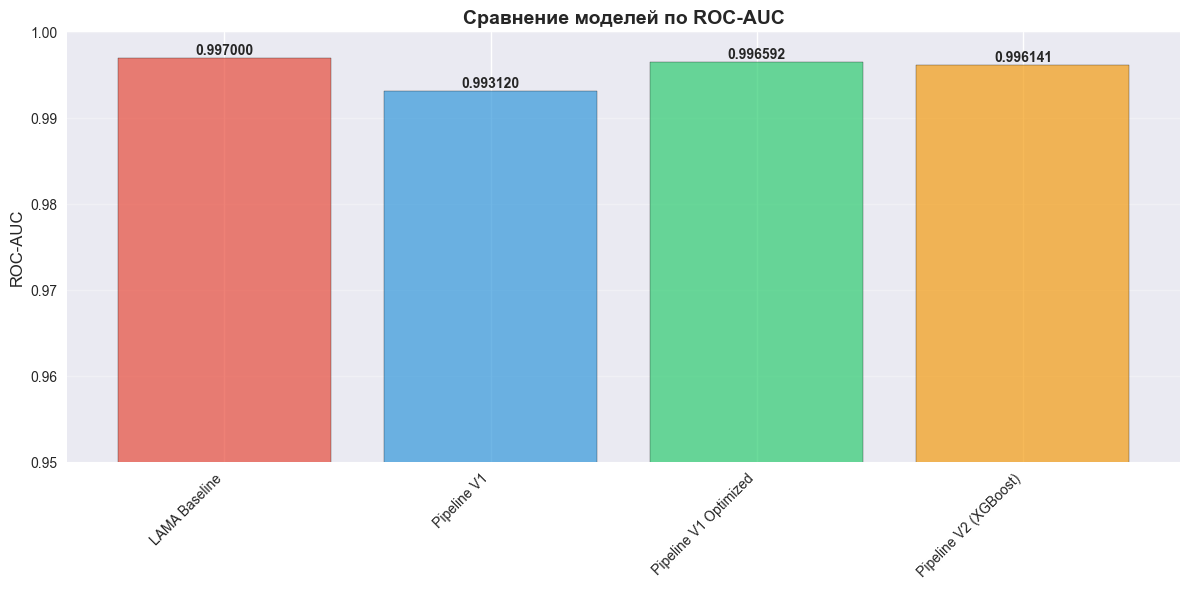

In [ ]:
comparison_data = {
    'Model': ['LAMA Baseline', 'Pipeline V1', 'Pipeline V1 Optimized', 'Pipeline V2 (XGBoost)'],
    'ROC-AUC': [0.997, roc_auc_v1, roc_auc_best, roc_auc_v2],
    'Accuracy': [None, accuracy_v1, accuracy_best, accuracy_v2],
    'F1-Score': [None, f1_v1, f1_best, f1_v2]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*60)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*60)
display(comparison_df)

fig, ax = plt.subplots(figsize=(12, 6))
models = comparison_df['Model']
roc_aucs = [x if x is not None else 0 for x in comparison_df['ROC-AUC']]
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

bars = ax.bar(models, roc_aucs, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('Сравнение моделей по ROC-AUC', fontsize=14, fontweight='bold')
ax.set_ylim([0.95, 1.0])
ax.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, roc_aucs):
    if value > 0:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.6f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(RESULTS_DIR / "models" / "models_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

## Шаг 5.8: Обучение финальной модели на полном train set

In [31]:
print("Обучение финальной модели на полном train set...")

def preprocess_test_data(train_df, test_df, numeric_features, categorical_features, target_col='class'):
    """Предобрабатывает test данные без целевой переменной."""
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import RobustScaler
    
    numeric_imputer = SimpleImputer(strategy='median')
    numeric_scaler = RobustScaler()
    
    X_train_num = train_df[numeric_features].copy()
    X_test_num = test_df[numeric_features].copy()
    
    X_train_num_imputed = pd.DataFrame(
        numeric_imputer.fit_transform(X_train_num),
        columns=numeric_features,
        index=X_train_num.index
    )
    X_test_num_imputed = pd.DataFrame(
        numeric_imputer.transform(X_test_num),
        columns=numeric_features,
        index=X_test_num.index
    )
    
    X_train_num_scaled = pd.DataFrame(
        numeric_scaler.fit_transform(X_train_num_imputed),
        columns=numeric_features,
        index=X_train_num_imputed.index
    )
    X_test_num_scaled = pd.DataFrame(
        numeric_scaler.transform(X_test_num_imputed),
        columns=numeric_features,
        index=X_test_num_imputed.index
    )
    
    X_train_cat = train_df[categorical_features].copy().fillna('_missing_')
    X_test_cat = test_df[categorical_features].copy().fillna('_missing_')
    
    X_train_cat_encoded = pd.get_dummies(X_train_cat, columns=categorical_features, prefix=categorical_features)
    X_test_cat_encoded = pd.get_dummies(X_test_cat, columns=categorical_features, prefix=categorical_features)
    
    all_cat_cols = set(X_train_cat_encoded.columns) | set(X_test_cat_encoded.columns)
    
    train_cat_final = pd.DataFrame(0, index=X_train_cat_encoded.index, columns=sorted(all_cat_cols))
    test_cat_final = pd.DataFrame(0, index=X_test_cat_encoded.index, columns=sorted(all_cat_cols))
    
    for col in X_train_cat_encoded.columns:
        train_cat_final[col] = X_train_cat_encoded[col]
    for col in X_test_cat_encoded.columns:
        test_cat_final[col] = X_test_cat_encoded[col]
    
    X_train_processed = pd.concat([X_train_num_scaled, train_cat_final], axis=1)
    X_test_processed = pd.concat([X_test_num_scaled, test_cat_final], axis=1)
    
    common_cols = X_train_processed.columns.intersection(X_test_processed.columns)
    X_train_processed = X_train_processed[common_cols]
    X_test_processed = X_test_processed[common_cols]
    
    missing_cols = X_train_processed.columns.difference(X_test_processed.columns)
    for col in missing_cols:
        X_test_processed[col] = 0
    X_test_processed = X_test_processed[X_train_processed.columns]
    
    le = LabelEncoder()
    y_train = le.fit_transform(train_df[target_col])
    
    return X_train_processed, X_test_processed, y_train, le

X_train_full, X_test_full, y_train_full, le_target_full = preprocess_test_data(
    train_df, test_df,
    feature_types['numeric'],
    feature_types['categorical']
)

print(f"X_train_full: {X_train_full.shape}")
print(f"X_test_full: {X_test_full.shape}")

final_selector = SelectKBest(score_func=f_classif, k=best_params.get('n_features', 100))
X_train_final_full = final_selector.fit_transform(X_train_full, y_train_full)
X_test_final_full = final_selector.transform(X_test_full)

final_model = RandomForestClassifier(
    n_estimators=best_params.get('n_estimators', 300),
    max_depth=best_params.get('max_depth', 19),
    min_samples_split=best_params.get('min_samples_split', 10),
    min_samples_leaf=best_params.get('min_samples_leaf', 1),
    max_features=best_params.get('max_features', 'log2'),
    random_state=42,
    n_jobs=-1
)

print("Обучение модели...")
final_model.fit(X_train_final_full, y_train_full)

y_test_pred = final_model.predict(X_test_final_full)
y_test_pred_classes = le_target_full.inverse_transform(y_test_pred)

submission = pd.DataFrame({
    'id': test_df['id'],
    'class': y_test_pred_classes
})

submission.to_csv(RESULTS_DIR / "submissions" / "notebook_submission.csv", index=False)

print("ФИНАЛЬНАЯ МОДЕЛЬ ОБУЧЕНА")
print(f"\nSubmission файл создан: {RESULTS_DIR / 'submissions' / 'notebook_submission.csv'}")
print(f"Размер submission: {submission.shape}")
print(f"\nРаспределение классов:")
print(submission['class'].value_counts())

Обучение финальной модели на полном train set...
X_train_full: (3116945, 1104)
X_test_full: (2077964, 1104)
Обучение модели...
ФИНАЛЬНАЯ МОДЕЛЬ ОБУЧЕНА

Submission файл создан: /Users/gurevamila/nikita/auto_ml/results/submissions/notebook_submission.csv
Размер submission: (2077964, 2)

Распределение классов:
class
p    1131958
e     946006
Name: count, dtype: int64


# ЭТАП 6: Общие требования к коду

## Шаг 6.2: Создание единого Pipeline класса

In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='_missing_')),
    ('encoder', 'passthrough')
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_types['numeric']),
        ('cat', categorical_transformer, feature_types['categorical'])
    ],
    remainder='drop'
)

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=100)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

print("\nСтруктура pipeline:")
print(full_pipeline)
print("\nPipeline готов к использованию")


Структура pipeline:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='_missing_',
                                                                                 strategy='constant')),
  

# ЭТАП 7: Финальная документация и отчет

## Итоговые результаты и выводы в README